# <font color='red'>DSP_002 - High Value Customer Identification (Insiders)

# Basic setups

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import umap.umap_ as umap
#!pip install umap-learn 
from IPython.core.display     import HTML
from matplotlib import pyplot as plt
from pandas_profiling import ProfileReport 
from sklearn import cluster       as c
from sklearn import metrics       as m
from sklearn import ensemble      as en
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import mixture       as mx
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from scipy.cluster import hierarchy as hc
from plotly import express as px

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Supress Scientific Notation
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Data Exploring

## Data Load

In [4]:
df_raw =pd.read_csv('../data/raw/Ecommerce.csv', sep=',', decimal='.', encoding = 'ISO-8859-1')

## Data Overview

In [5]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Unnamed: 8
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.00,United Kingdom,NaN
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.00,United Kingdom,NaN
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.00,United Kingdom,NaN


In [6]:
print('The original dataset has {} transations registers with {} attributes.'.format(df_raw.shape[0], df_raw.shape[1]) )

The original dataset has 541909 transations registers with 9 attributes.


In [7]:
df_raw.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Unnamed: 8'],
      dtype='object')

## Check NaN

In [8]:
df_raw.isna().sum() / len(df_raw) *100

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
Unnamed: 8    100.00
dtype: float64

There are a considerable number of transations without customers. Identify the customers is the main objective of this project, so this is a big problem. Through this cycle, we have a lot of problems with non identified customers, so we decided to drop then in this 
first cycle of the project. Maybe in the next cycle something different can be done. After all, we discovery that dropping all the clientes without id, we drop all the "descriptions" NaN as well.

## Data types

In [9]:
df_raw.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
Unnamed: 8     float64
dtype: object

## Check duplicated

In [10]:
df_raw['CustomerID'].duplicated().sum()

537536

In [11]:
df_raw[df_raw.duplicated()].shape

(5269, 9)

From a business perspective, none of the repeated attributes will be a problem unless there are more than one record with all inputs duplicated.

## Statistics data overview

In [12]:
df_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
UnitPrice,541909.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
CustomerID,406829.00,15287.69,1713.60,12346.00,13953.00,15152.00,16791.00,18287.00
Unnamed: 8,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Tasks:

    01) Change the columns names to snacke case;
    02) Drop "Unnamed: 8" column;
    03) Check NaN ("Description" and "CustomerID");
    04) Change types (InvoiceNo, InvoiceDate and CustomerID;
    05) Solve duplicated registers
    06) Check the invoices with letters;
    07) Check the strange description names;
    08) Check negative unit prices and quantities

# <font color='green'> Data Processing

In [13]:
df3 = df_raw.copy()

## Rename columns

In [14]:
df3.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'Unnamed: 8'],
      dtype='object')

In [15]:
cols_new = ['invoice_no', 'stock_code', 'description','quantity', 'invoice_date','unit_price', 'customer_id', 'country', 'unnamed']

In [16]:
df3.columns = cols_new #change to snake case

## Check "Unnamed: 8" attribute

All the Unnamed are NaN. There is no relevante information in this feature. It will be dropped.

In [17]:
df3 = df3.drop(columns=['unnamed'], axis=1) 

## Solving NaN

In [18]:
df3.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [19]:
df3 = df3.dropna(subset = ['customer_id'], axis=0)

In [20]:
df3.isna().sum()

invoice_no      0
stock_code      0
description     0
quantity        0
invoice_date    0
unit_price      0
customer_id     0
country         0
dtype: int64

The "description" NaN were dropped together with the "customer_id" NaN

## Change dtypes

### Attribute 'invoice_number'

In [21]:
df3['invoice_no'].unique()

array(['536365', '536366', '536367', ..., '581585', '581586', '581587'],
      dtype=object)

In [22]:
#df3['invoice_no'] = df3['invoice_no'].astype(int64)
print('According with the code error, there are invoices with number with letters. For now it will be keep as a object')

According with the code error, there are invoices with number with letters. For now it will be keep as a object


### Attribute 'invoice_date'

In [23]:
df3['invoice_date'] = pd.to_datetime(df3['invoice_date'], format = '%d-%b-%y')
# use %b because the month is in a string in the df

In [24]:
df3.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id            float64
country                 object
dtype: object

### Attribute 'customer_id'

In [25]:
df3['customer_id'] = df3['customer_id'].astype(int64)

In [26]:
df3.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Solve Duplicates

In [27]:
#next cycle

## Negative values

From here, we have to take a direction. The negative values problably are from returns. We can just exclude them, exclude the in an out or we can create features for returns. From this point, we decided to sum all the values for customer, and those who ended up with a negative or zero amount will be dropped. We can divided the dataframe in two, one with the purchases, one just with the returns, but it will be done in the next cycle.

In [28]:
df3['subtotal'] = df3['unit_price'] * df3['quantity'] 

In [29]:
df_customers = df3[['customer_id','subtotal']].groupby('customer_id').sum().reset_index()

In [30]:
bad_customers = df_customers[df_customers['subtotal'] <= 0.0]

In [31]:
print('There are {} customers with negative or equal zero total purchases.'.format(bad_customers.shape[0]))

There are 50 customers with negative or equal zero total purchases.


In [32]:
bad_list = bad_customers['customer_id'].to_list()

In [33]:
df3 = df3[~df3['customer_id'].isin(bad_list)] # throw out the bad customers

In [34]:
df3.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,406526.00,12.04,185.50,-80995.00,2.00,5.00,12.00,80995.00
unit_price,406526.00,3.43,68.91,0.00,1.25,1.95,3.75,38970.00
customer_id,406526.00,15287.30,1713.57,12347.00,13952.00,15152.00,16791.00,18287.00
subtotal,406526.00,20.45,391.92,-168469.60,4.20,11.25,19.50,168469.60


## Attribute invoice_no

First, we have to identify and try to discover what the mean of the invoices with letters.

In [35]:
df_letter_invoices = df3.loc[df3['invoice_no'].apply (lambda x: bool(re.search ( '[^0-9]+', x))), :] 
df_letter_invoices.sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,subtotal
211337,C555366,22355,CHARLOTTE BAG SUKI DESIGN,-2,2017-05-31,0.72,12590,Germany,-1.44
387472,C570290,23207,LUNCH BAG ALPHABET DESIGN,-10,2017-10-08,1.65,14665,United Kingdom,-16.50
391859,C570683,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,-1,2017-10-09,2.08,16161,United Kingdom,-2.08
304662,C563593,D,Discount,-1,2017-08-16,206.40,14646,Netherlands,-206.40
140731,C548460,22365,DOORMAT RESPECTABLE HOUSE,-2,2017-03-29,7.95,16801,United Kingdom,-15.90
170530,C551316,21703,BAG 125g SWIRLY MARBLES,-12,2017-04-25,0.42,15220,United Kingdom,-5.04
445079,C574753,22720,SET OF 3 CAKE TINS PANTRY DESIGN,-2,2017-11-05,4.95,13924,United Kingdom,-9.90
96392,C544558,22360,GLASS JAR ENGLISH CONFECTIONERY,-11,2017-02-19,2.55,16073,United Kingdom,-28.05
278383,C561210,23263,SET OF 3 WOODEN HEART DECORATIONS,-10,2017-07-23,1.25,17841,United Kingdom,-12.50
123585,C546901,22232,JIGSAW TOADSTOOLS 3 PIECE,-8,2017-03-15,1.65,14112,United Kingdom,-13.20


In [36]:
df_letter_invoices.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,8711.00,-22.64,876.26,-80995.00,-6.00,-2.00,-1.00,-1.00
unit_price,8711.00,18.06,446.30,0.01,1.45,2.95,4.95,38970.00
customer_id,8711.00,14975.88,1704.20,12352.00,13495.00,14854.00,16393.00,18282.00
subtotal,8711.00,-59.38,1866.11,-168469.60,-16.95,-8.40,-3.30,-0.12


All those letter invoices are from negative quantities. Lets check the invoice just with letters:

In [37]:
df3.loc[df3['stock_code'].apply (lambda x:bool (re.search('^[a-zA-Z]+$', x ) ) ), 'stock_code' ].value_counts()

POST    1196
M        444
D         77
DOT       16
CRUK      16
PADS       4
Name: stock_code, dtype: int64

Stock codes to be dropped: 'POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'

In [38]:
df3 = df3[~df3['stock_code'].isin (['POST', 'D', 'DOT', 'M', 'PADS', 'CRUK'])]

## Description filter

Throughout the work, several strange names were observed in the description of the items. It was decided to exclude them after all other cleaning operations because it seems that many of them were returns or discounts, so they would be eliminated throughout the process. However, a final cleaning will be done before the generation of new features to ensure the integrity of the results of the machine learning models.

In [39]:
df3['description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ...,
       'PINK CRYSTAL SKULL PHONE CHARM',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

# <font color='orange'> Feature Engineering

In [40]:
df4 = df3.copy()

In [41]:
df4.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,subtotal
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34


## Average Ticket

In [42]:
avg_ticket_df = df4[['customer_id','invoice_no','subtotal']].groupby(['customer_id','invoice_no']).sum().reset_index()

In [43]:
avg_ticket_df.rename(columns = {'subtotal':'avg_ticket'}, inplace = True)            

In [44]:
avg_ticket_df = avg_ticket_df[['customer_id','avg_ticket']].groupby('customer_id').mean().reset_index()

In [45]:
avg_ticket_df.head()

,customer_id,avg_ticket
0,12347,615.71
1,12348,359.31
2,12349,1457.55
3,12350,294.40
4,12352,158.18


In [46]:
df4 = pd.merge(df4,avg_ticket_df, on ='customer_id', how = 'left')

In [47]:
df4.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,subtotal,avg_ticket
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,151.10
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,151.10
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10


In [48]:
df4['customer_id'].unique().size

4321

## recency

In [49]:
# day from the last purchase until the last date of the dataset
df_recency = df4[['customer_id','invoice_date']].groupby('customer_id').max().reset_index()

df_recency['recency'] = (df4['invoice_date'].max() - df_recency['invoice_date']).dt.days


In [50]:
# one day shif to avoid zero division
df_recency['recency'] = df_recency['recency'].apply(lambda x: x+1)

In [51]:
df_recency['recency'] = df_recency['recency'].apply(lambda x: 100/x)

In [52]:
df4=pd.merge(df4, df_recency[['customer_id','recency']], on = 'customer_id', how='left')

In [53]:
df4.sample(10)

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,subtotal,avg_ticket,recency
199486,561507,23241,TREASURE TIN GYMKHANA DESIGN,6,2017-07-25,2.08,12397,Belgium,12.48,1107.45,2.78
176949,558754,84692,BOX OF 24 COCKTAIL PARASOLS,6,2017-07-01,0.42,15518,United Kingdom,2.52,159.89,1.54
51914,543193,47559B,TEA TIME OVEN GLOVE,10,2017-02-02,1.25,13725,United Kingdom,12.50,164.53,2.00
184193,559684,22411,JUMBO SHOPPER VINTAGE RED PAISLEY,10,2017-07-09,2.08,14367,United Kingdom,20.80,482.52,11.11
373301,578420,48188,DOORMAT WELCOME PUPPIES,2,2017-11-22,8.25,16326,United Kingdom,16.50,205.73,16.67
82679,546912,20724,RED RETROSPOT CHARLOTTE BAG,4,2017-03-15,0.85,15861,United Kingdom,3.40,333.37,7.69
228939,564731,23308,SET OF 60 VINTAGE LEAF CAKE CASES,24,2017-08-26,0.55,16186,United Kingdom,13.20,307.07,4.35
236661,565750,21136,PAINTED METAL PEARS ASSORTED,8,2017-09-04,1.69,14208,United Kingdom,13.52,151.74,1.05
106338,549835,22768,FAMILY PHOTO FRAME CORNICE,16,2017-04-10,8.50,17511,United Kingdom,136.00,1958.63,33.33
313010,572909,22993,SET OF 4 PANTRY JELLY MOULDS,3,2017-10-24,1.25,15821,United Kingdom,3.75,285.48,2.22


## gross_revenue

In [54]:
df_revenue = df4[['subtotal', 'customer_id']].copy()

In [55]:
df_revenue = df_revenue.groupby('customer_id').sum().reset_index() #total per customer
df_revenue.rename(columns = {'subtotal':'gross_revenue'}, inplace = True)
df_revenue.head()

,customer_id,gross_revenue
0,12347,4310.00
1,12348,1437.24
2,12349,1457.55
3,12350,294.40
4,12352,1265.41


In [56]:
df4 = pd.merge(df4, df_revenue, on='customer_id', how='left')

In [57]:
df4.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,subtotal,avg_ticket,recency,gross_revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,151.10,0.33,5288.63
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10,0.33,5288.63
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,151.10,0.33,5288.63
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10,0.33,5288.63
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10,0.33,5288.63


## Frequency

In [58]:
df_frequency = df4[['customer_id', 'invoice_no']]

In [59]:
df_frequency = df_frequency.drop_duplicates(subset = 'invoice_no')
df_frequency = df_frequency.groupby('customer_id').count().reset_index() # number of purchases for customer within the dataset

In [60]:
df_frequency.rename(columns={'invoice_no':'frequency'}, inplace = True)

In [61]:
df4 = pd.merge(df4, df_frequency, on='customer_id', how = 'left')

In [62]:
df4.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country,subtotal,avg_ticket,recency,gross_revenue,frequency
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2016-11-29,2.55,17850,United Kingdom,15.30,151.10,0.33,5288.63,35
1,536365,71053,WHITE METAL LANTERN,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10,0.33,5288.63,35
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2016-11-29,2.75,17850,United Kingdom,22.00,151.10,0.33,5288.63,35
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10,0.33,5288.63,35
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2016-11-29,3.39,17850,United Kingdom,20.34,151.10,0.33,5288.63,35


# Data Filtering

In [63]:
df5 = df4.copy()

In [64]:
df5.dtypes

invoice_no               object
stock_code               object
description              object
quantity                  int64
invoice_date     datetime64[ns]
unit_price              float64
customer_id               int64
country                  object
subtotal                float64
avg_ticket              float64
recency                 float64
gross_revenue           float64
frequency                 int64
dtype: object

In [65]:
df5.drop(columns = ['stock_code','country','description','quantity','unit_price' ,'subtotal','invoice_date','invoice_no'], axis = 1, inplace = True) # we don't need this features

In [66]:
df5.drop_duplicates(subset = 'customer_id', inplace = True)
df5 = df5.reset_index(drop=True)
df5.head()

,customer_id,avg_ticket,recency,gross_revenue,frequency
0,17850,151.10,0.33,5288.63,35
1,13047,193.07,2.13,3089.10,16
2,12583,389.96,33.33,6629.34,17
3,13748,189.65,1.04,948.25,5
4,15100,105.85,0.30,635.10,6


In [67]:
# Filter customer with very low gross revenue

In [68]:
df5.drop(df5[df5['gross_revenue'] < 1].index, inplace = True)

# Exploratory data analysis (EDA)

In [69]:
df6 = df5.copy()

In [70]:
#profile = ProfileReport(df6)
#profile.to_file(r'../reports/profile_report.html')

In [71]:
df6.describe().T

,count,mean,std,min,25%,50%,75%,max
customer_id,4316.00,15299.53,1720.00,12347.00,13814.75,15298.50,16777.25,18287.00
avg_ticket,4316.00,326.55,390.51,0.97,154.99,241.05,372.20,9904.88
recency,4316.00,6.77,13.23,0.27,0.72,2.00,5.88,100.00
gross_revenue,4316.00,1922.41,8324.49,2.90,301.00,656.00,1611.72,278778.02
frequency,4316.00,5.03,9.14,1.00,1.00,3.00,5.00,243.00


## Descriptive Statistics

In [72]:
num_attributes = df6.drop(columns = ['customer_id'], axis = 1)

In [73]:
#central tendency - mean, median
ct1 = pd.DataFrame ( num_attributes.apply (np.mean) ).T
ct2 = pd.DataFrame ( num_attributes.apply (np.median)).T
                    
# dispersion - desvio padrão, mínimo, máximo, range, skew, kurtosis
d1 = pd.DataFrame ( num_attributes.apply (np.std)).T
d2 = pd.DataFrame ( num_attributes.apply (np.min)).T
d3 = pd.DataFrame ( num_attributes.apply (np.max)).T
d4 = pd.DataFrame ( num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame ( num_attributes.apply (lambda x: x.skew() )).T
d6 = pd.DataFrame ( num_attributes.apply (lambda x: x.kurtosis() ) ).T

#concatenate

df_metrics = pd.concat ([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
df_metrics.columns = ['attributes', 'min.','max','range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [74]:
df_metrics

,attributes,min.,max,range,mean,median,std,skew,kurtosis
0,avg_ticket,0.97,9904.88,9903.91,326.55,241.05,390.47,8.85,136.17
1,recency,0.27,100.00,99.73,6.77,2.00,13.23,4.15,21.68
2,gross_revenue,2.90,278778.02,278775.12,1922.41,656.00,8323.52,21.50,595.24
3,frequency,1.00,243.00,242.00,5.03,3.00,9.14,11.43,221.90


# <font color='red'>Data Preparation

In [75]:
df7 = df6.copy()

In [76]:
ss = pp.StandardScaler()
df7['avg_ticket']    = ss.fit_transform (df7[['avg_ticket']])
df7['recency']       = ss.fit_transform (df7[['recency']])
df7['gross_revenue'] = ss.fit_transform (df7[['gross_revenue']])
df7['frequency']     = ss.fit_transform (df7[['frequency']])

In [77]:
df7.head()

,customer_id,avg_ticket,recency,gross_revenue,frequency
0,17850,-0.45,-0.49,0.40,3.28
1,13047,-0.34,-0.35,0.14,1.20
2,12583,0.16,2.01,0.57,1.31
3,13748,-0.35,-0.43,-0.12,-0.00
4,15100,-0.57,-0.49,-0.15,0.11


# <font color='red'>Feature Selection

In [78]:
df8 = df7.copy()

In [79]:
df8.head()

,customer_id,avg_ticket,recency,gross_revenue,frequency
0,17850,-0.45,-0.49,0.40,3.28
1,13047,-0.34,-0.35,0.14,1.20
2,12583,0.16,2.01,0.57,1.31
3,13748,-0.35,-0.43,-0.12,-0.00
4,15100,-0.57,-0.49,-0.15,0.11


# <font color='red'>Hyperparameter Fine-Tunning

In [80]:
df9 = df8.copy()

O número de clusters é nosso principal hiperparâmetro, pois não temos essa resposta.  Antes de treinar os modelos precisamos saber quantos clusters vamos considerar. Utilizamos o Kmeans para efetuar a clusterização em um range de 2 a 7 clusters, e utilizando duas métricas, a WSS e a Silhouette Score, escolhemos o número adequado de clusters. A partir daí temos um ponto de partida para treinar os diversos modelos.

In [95]:
X = df9.drop(columns =  ['customer_id'],  axis=1) 
clusters = [2,3,4,5,6,7] # cluster range

## Within-Cluster Sum of Square (WSS)

In [96]:
wss = [] #lista para guardar as métricas para cada iteração do modelo. Cada número de cluster irá gerar um valor

for k in clusters:
    #model definition
    kmeans = c.KMeans (init = 'random' , n_clusters=k, n_init=10, max_iter=300)
    #model training
    kmeans.fit ( X )
    #validation
    wss.append (kmeans.inertia_) #inertia é o próprio valor wss

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

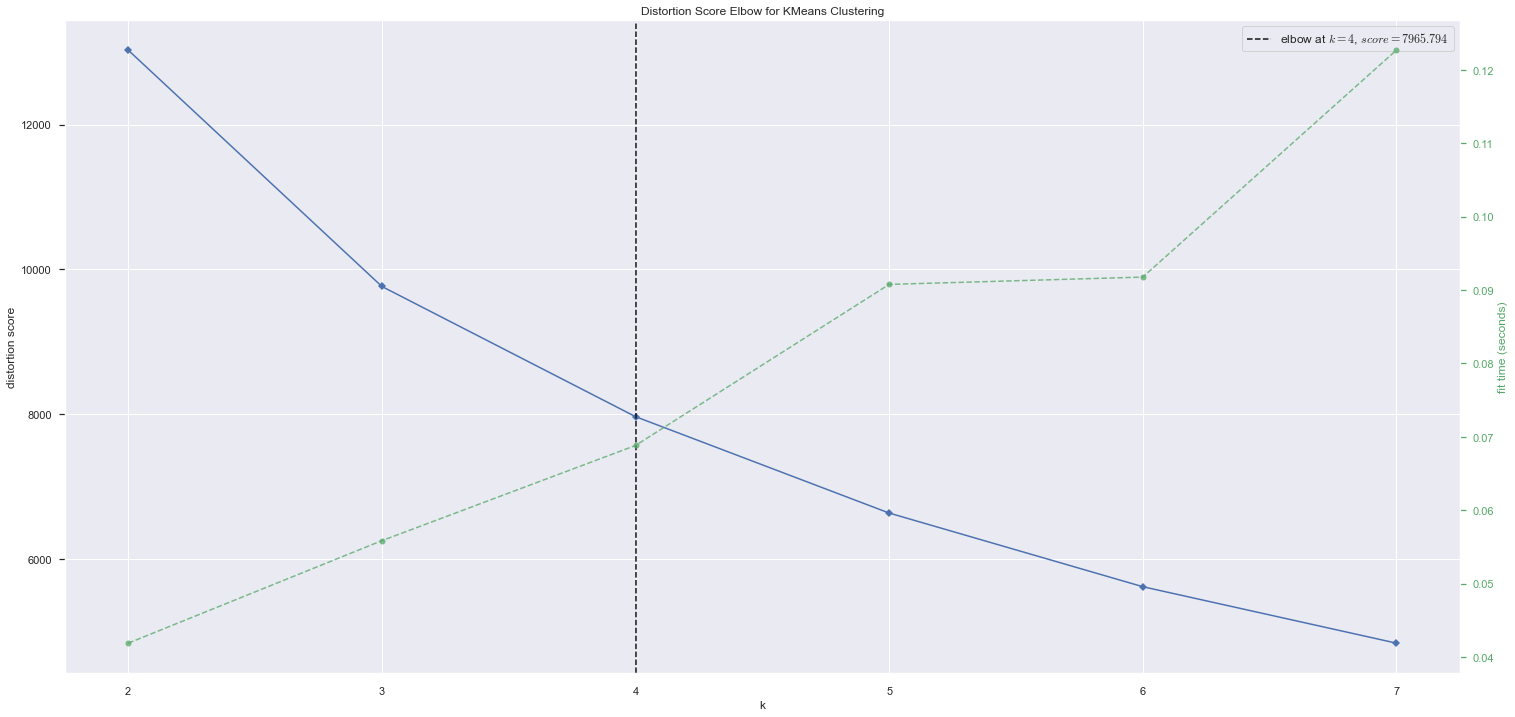

In [97]:
#plot elbow method
kmeans = KElbowVisualizer (c.KMeans(), k=clusters, timing=False)
kmeans.fit(X)
kmeans.show(outpath = r'../reports/figures/wss_cluster_metrics.png')

## Silhouette Score

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

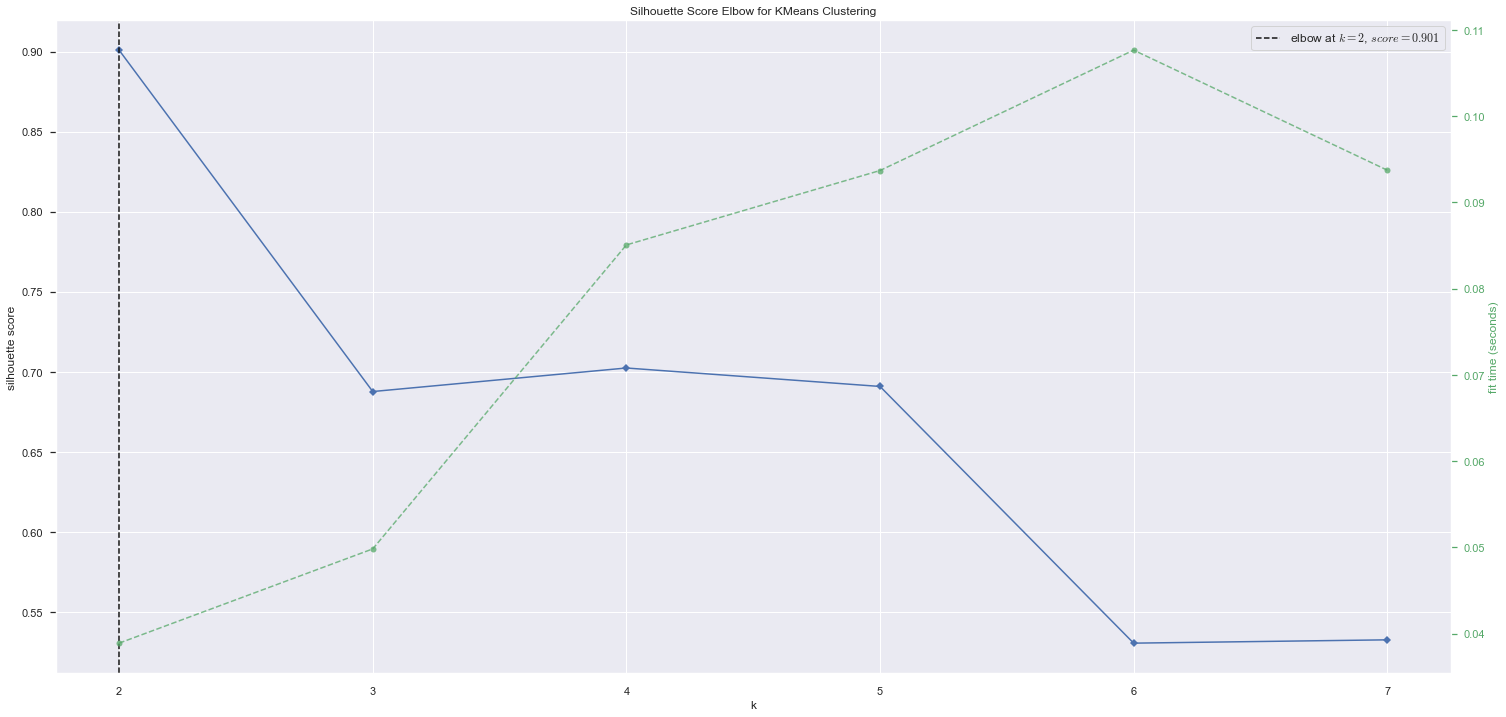

In [98]:
kmeans = KElbowVisualizer ( c.KMeans(), k=clusters, metric = 'silhouette', timings = True)
kmeans.fit(X)
kmeans.show(outpath = r'../reports/figures/silhouette_cluster_metrics.png')

## Silhouette Analysis

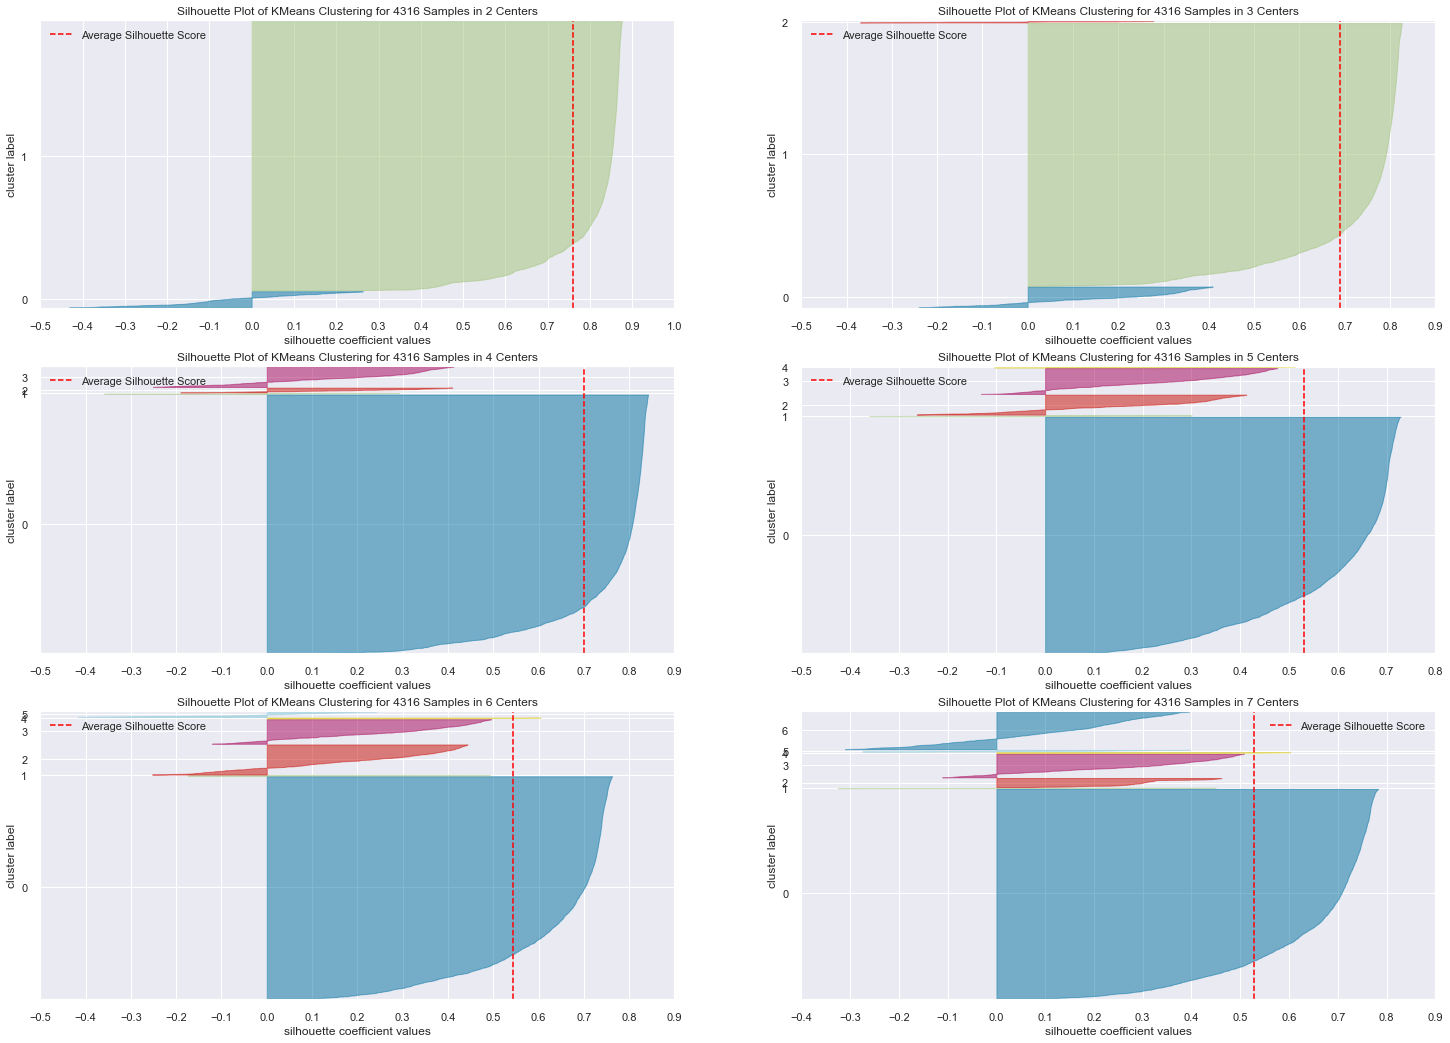

In [99]:
fig, ax = plt.subplots (3,2, figsize=(25,18))

for k in clusters:
    km = c.KMeans (n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q,mod = divmod(k,2) #truque para distribuição dos plots
    visualizer = SilhouetteVisualizer (km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()
plt.savefig(r'../reports/figures/silhouette_cluster_analysis.png')

# Model training

## K-Means

In [100]:
# model definition
k = 4
kmeans = c.KMeans (init='random', n_clusters=k, n_init=10, max_iter=300, random_state = 42)
# model training
kmeans.fit (X)
#clustering
labels = kmeans.labels_

## Cluster Validation

In [101]:
# WSS
print('WSS value: {}'.format (kmeans.inertia_))
# SS
print ('SS value: {}'.format(m.silhouette_score(X, labels, metric='euclidean')))

WSS value: 7935.263712453979
SS value: 0.7007005873328439


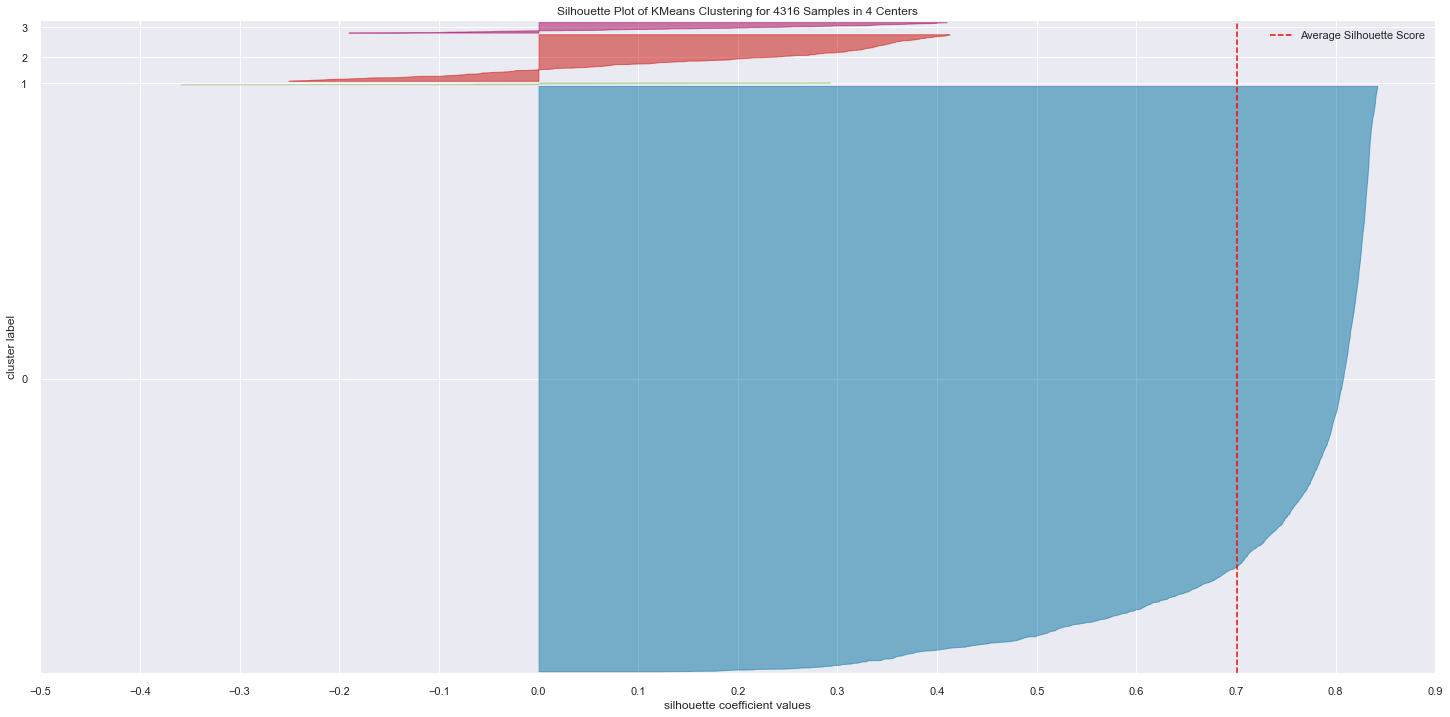

In [102]:
#cluster inspection
visualizer = SilhouetteVisualizer (kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

# Cluster visual inspection

In [108]:
df_viz = df9.drop(columns =  ['customer_id'],  axis=1)
df_viz['cluster'] = labels
reducer = umap.UMAP (n_neighbors = 20, random_state = 42) # instancia o objeto
embedding = reducer.fit_transform (X)

In [109]:
# embedding
df_viz['embedding_x'] = embedding[:,0] # embedding é o espaço projetado
df_viz['embedding_y'] = embedding[:,1]

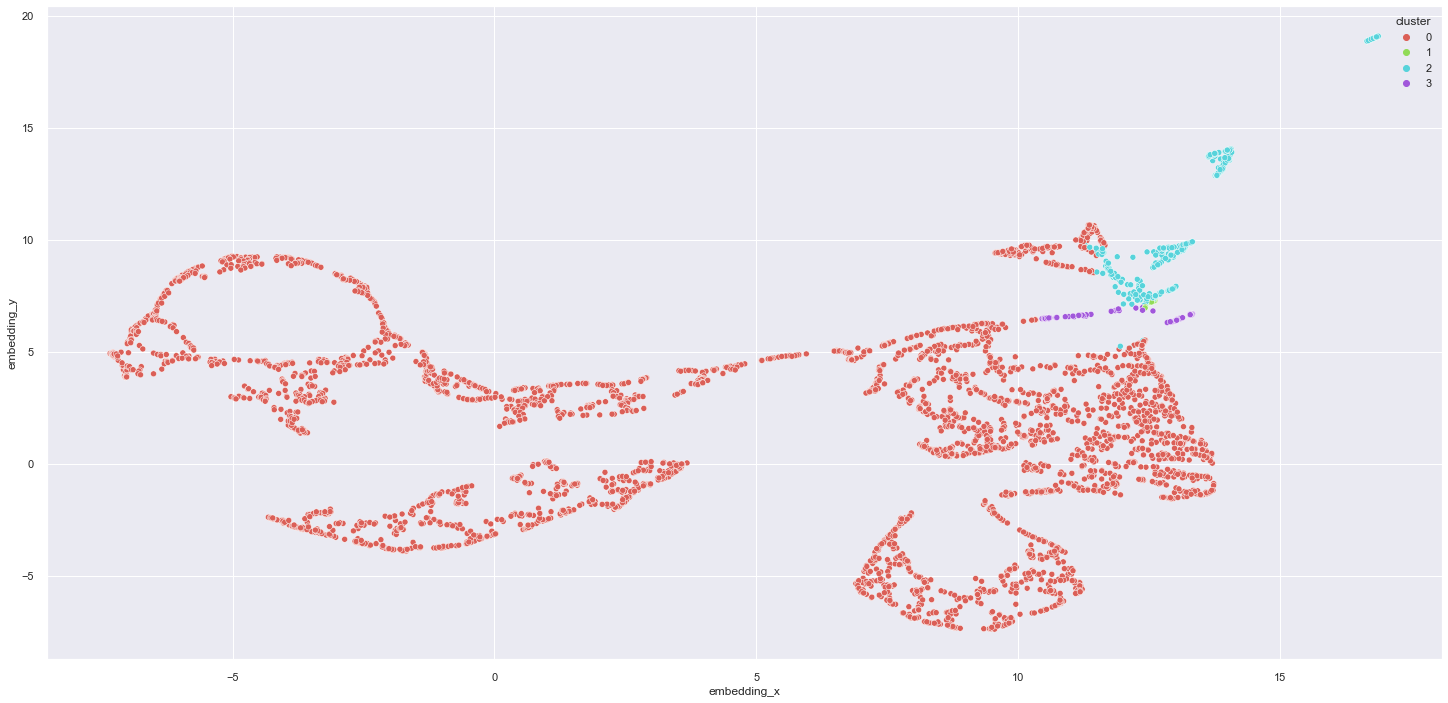

In [111]:
# plot UMAP
sns.scatterplot( x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette = sns.color_palette ('hls', n_colors = len(df_viz['cluster'].unique() ) ), data = df_viz )

plt.savefig(r'../reports/figures/umap_vizbathrooms.png')

# <font color='red'>Cluster Analysis

In [ ]:
df11 = df9.copy()
df11['cluster'] = labels

## Cluster Profile

In [ ]:
# clusters size
df_cluster = df11[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
# percentage of each cluster
df_cluster['perc_customer'] = 100*(df_cluster['customer_id'] /df_cluster['customer_id'].sum())
#avg gross revenue
df_avg_gross_revenue = df11[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_gross_revenue, how='inner', on='cluster')
#frequency
df_frequency = df11[['frequency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_frequency, how='inner', on='cluster')
#recency
df_recency = df11[['recency','cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_recency, how='inner', on='cluster')
df_cluster

# <font color='red'>Deploy to production